## Análise Exploratória em Conjunto de Dados do IMDb sobre os filmes

Neste trabalho será feita uma análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Usaremos dados reais disponíveis publicamente, dados sobre filmes no <a href="https://www.imdb.com/interfaces/">IMDB</a>.

Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? 
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Piores Filmes?
- 10- Quais São os Top 10 Melhores Filmes?

## Importando Bibliotecas

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando os Dados

Primeiro temos que baixar os dados!

In [2]:
%%time
!imdb-sqlite

2021-11-27 11:15:39,880 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 10.1 ms, sys: 5.98 ms, total: 16.1 ms
Wall time: 354 ms


In [3]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [4]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [5]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [6]:
# Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [7]:
# Vamos converter o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [8]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




> Agora começamos a Análise Exploratória dos Dados.

## 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos (filmes)?

In [9]:
# Cria a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type''' 

In [10]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [11]:
# Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,594996
1,short,843498
2,tvEpisode,6282068
3,tvMiniSeries,40802
4,tvMovie,133772
5,tvPilot,2
6,tvSeries,216832
7,tvShort,10366
8,tvSpecial,34958
9,video,254872


In [12]:
# Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [13]:
# Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,594996,7.048086
1,short,843498,9.991742
2,tvEpisode,6282068,74.414883
3,tvMiniSeries,40802,0.483324
4,tvMovie,133772,1.584610
5,tvPilot,2,0.000024
6,tvSeries,216832,2.568506
7,tvShort,10366,0.122792
8,tvSpecial,34958,0.414099
9,video,254872,3.019113


In [14]:
# Vamos criar um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restante

# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'

In [15]:
# Visualiza
others

{'COUNT': 721389, 'percentual': 8.545287694752078, 'type': 'others'}

In [16]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [17]:
# Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [18]:
# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [19]:
# Visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6282068,74.414883
1,short,843498,9.991742
3,others,721389,8.545288
0,movie,594996,7.048086


In [20]:
# Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

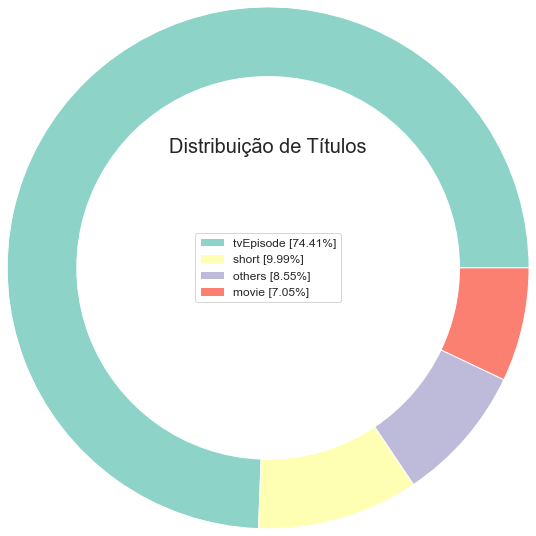

In [21]:
# Plot

# Mapa de cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## 2- Qual o Número de Títulos Por Gênero?

Vamos calcular o número de filmes por gênero e entregar o resultado em valor percentual.

In [22]:
# Cria a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 

In [23]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [24]:
# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13649
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",43
1447,War,1274
1448,"War,Western",12
1449,Western,5124


In [25]:
# Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [26]:
# Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero.

![title](imagens/one-hot.png)

In [27]:
# Vamos criar um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [28]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [29]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [30]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [31]:
# Retorna gêneros únicos
generos_unicos =  vetor.get_feature_names()

In [32]:
# Cria o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [33]:
# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  n            1451 non-null   int64
 19  news         1451 non-null   int64
 20  reality-

In [34]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [35]:
# Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [36]:
# Visualiza
generos_percentual.head(10)

drama          18.401103
comedy         16.884907
documentary    15.920055
adventure      14.886285
action         14.472777
romance        13.370090
crime          13.094418
mystery        12.405238
fantasy        12.336320
thriller       12.267402
dtype: float64

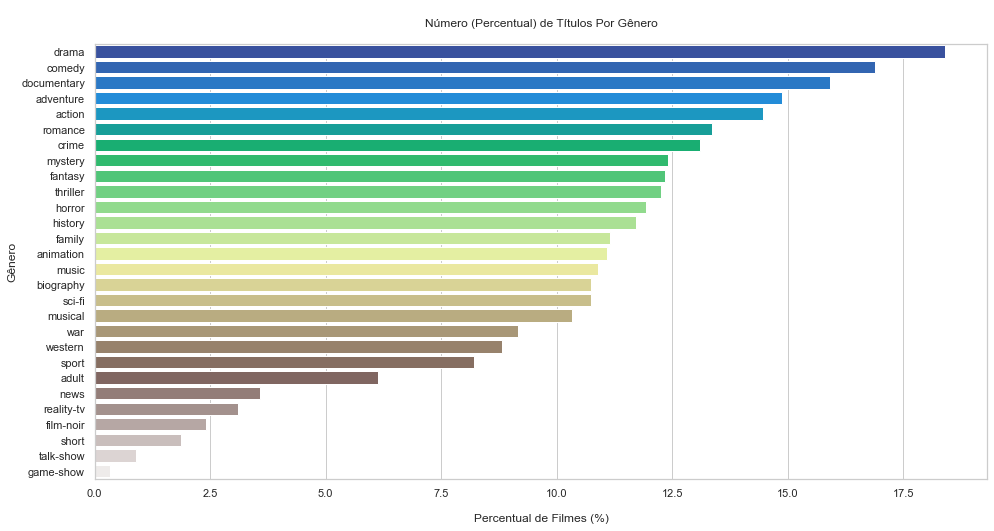

In [37]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [38]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [39]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [40]:
# Visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
271240,3.6,"Action,Adventure,Thriller"
271241,5.8,Thriller
271242,6.4,"Drama,History"
271243,3.8,"Adventure,History,War"


In [41]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [42]:
# Aplica a função
generos_unicos = retorna_generos(resultado3)

In [43]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [44]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

In [45]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [46]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [47]:
# Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28137,5.8
1,adult,4164,5.8
2,adventure,17143,6.0
3,animation,4773,6.4
4,biography,8168,7.0
5,comedy,67288,6.0
6,crime,23156,6.1
7,documentary,39995,7.3
8,drama,120287,6.4
9,family,10260,6.3


In [48]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [49]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

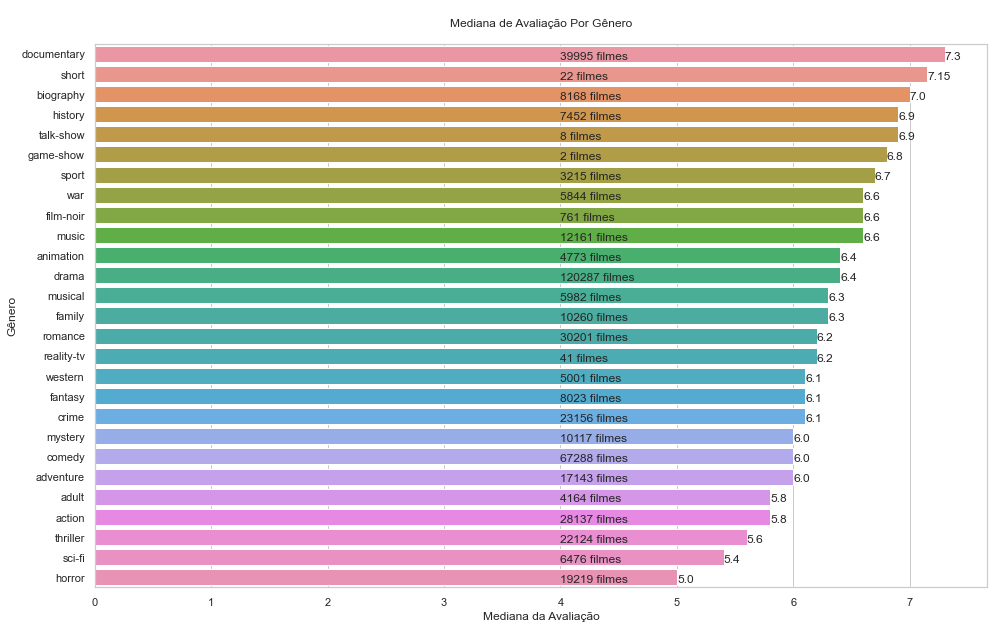

In [50]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [51]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [52]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [53]:
display(resultado4)

,Rating,premiered
0,6.4,1896
1,4.5,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
271240,8.6,2021
271241,7.7,2021
271242,5.6,2021
271243,6.0,2021


In [54]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [55]:
type(ratings)

list

In [56]:
ratings[1:10]

[4.5, 3.8, 5.9, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [57]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [58]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

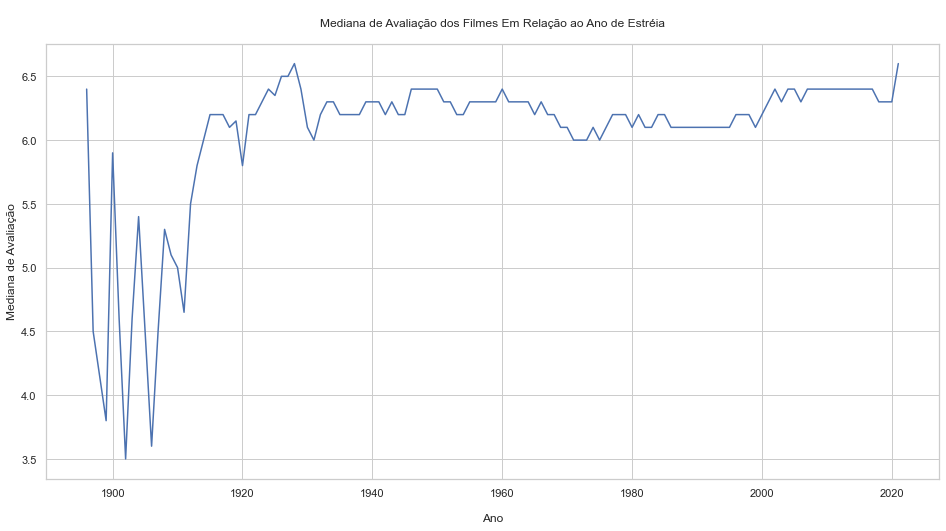

In [59]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [60]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles ''' 

In [61]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [62]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8441946,"Action,Drama,Family"
8441947,"Action,Drama,Family"
8441948,"Action,Drama,Family"
8441949,Short


In [63]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado5)

In [64]:
# Visualiza o resultado
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [65]:
# Agora fazemos a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [66]:
# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [67]:
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

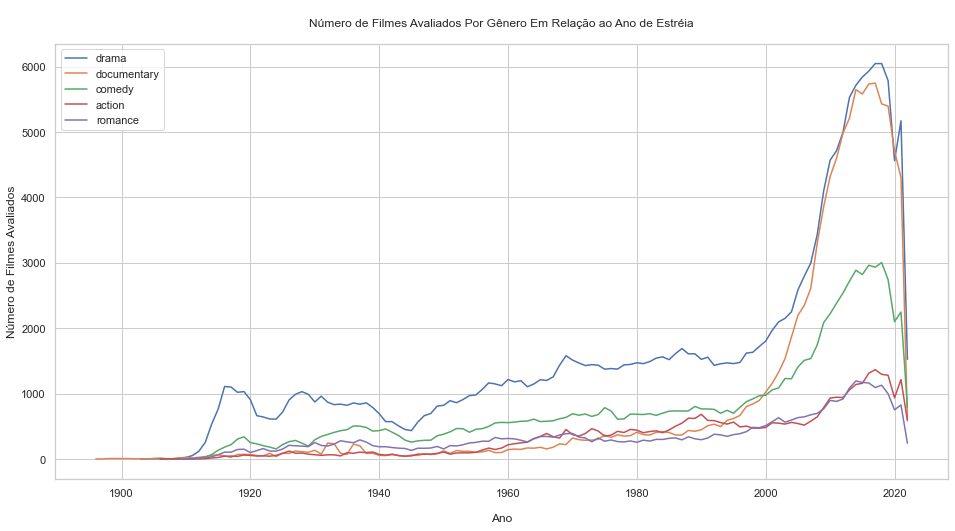

In [68]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.

Percentis e filme mais longo da história.

In [69]:
# Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [70]:
# Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [71]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
374083,123
374084,57
374085,100
374086,116


In [72]:
# Loop para cálculo dos percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [73]:
# Refazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [74]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [75]:
resultado6

,Runtime,primary_title
0,51420,Logistics


'Logistics' é o filme mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.

## 7- Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero.

In [76]:
# Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [77]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [78]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado7)

In [79]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [80]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [81]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [82]:
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [83]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

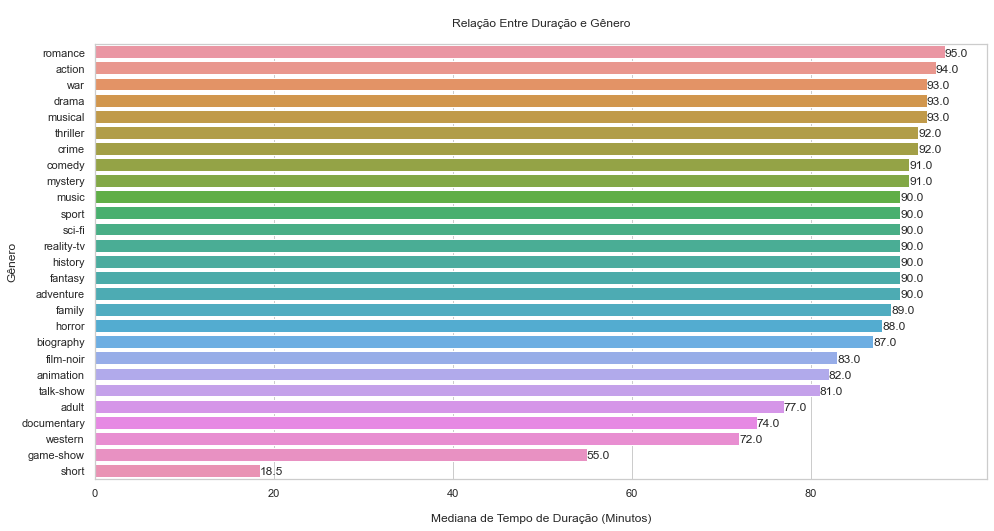

In [84]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país.

In [85]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [86]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [87]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,2996
2,AF,109
3,AG,12
4,AL,1248
...,...,...
229,YUCS,147
230,ZA,3098
231,ZM,12
232,ZRCD,2


In [88]:
# Shape
resultado8.shape

(234, 2)

In [89]:
# Número de linhas
resultado8.shape[0]

234

In [90]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [91]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [92]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [93]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [94]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,302396
65,United Kingdom,155171
96,Japan,89719
63,France,82770
89,India,76828
32,Canada,73183
47,Germany,68141
93,Italy,64232
58,Spain,63750
26,Brazil,63702


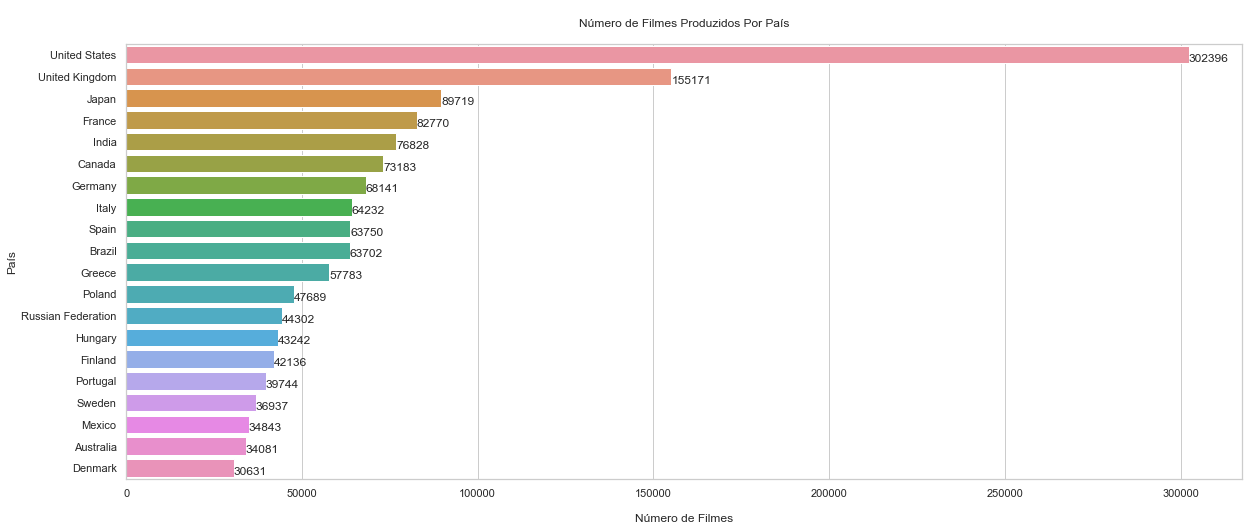

In [95]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

## 9- Quais São os Top 10 Melhores Filmes?

Top 10 filmes com melhor avaliação e mais de 25 mil votos.

In [96]:
# Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [97]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [98]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,Jai Bhim,"Crime,Drama",9.5
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Mirror Game,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


## 10- Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos.

In [99]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

In [100]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [101]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,The Cost of Deception,"Crime,Drama,History",1.4
4,Reis,"Biography,Drama",1.4
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,"Drama,Horror",1.8
7,Radhe,"Action,Crime,Thriller",1.8
8,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9


# Fim